In [1]:
!pip install numpy pandas

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
!pip install rrcf

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [4]:
import numpy as np
import pandas as pd
import rrcf
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
import seaborn as sns

# Read data
taxi = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv',
                   index_col=0)
taxi.index = pd.to_datetime(taxi.index)
data = taxi['value'].astype(float).values

In [5]:
# Create events
events = {
'independence_day' : ('2014-07-04 00:00:00',
                      '2014-07-07 00:00:00'),
'labor_day'        : ('2014-09-01 00:00:00',
                      '2014-09-02 00:00:00'),
'labor_day_parade' : ('2014-09-06 00:00:00',
                      '2014-09-07 00:00:00'),
'nyc_marathon'     : ('2014-11-02 00:00:00',
                      '2014-11-03 00:00:00'),
'thanksgiving'     : ('2014-11-27 00:00:00',
                      '2014-11-28 00:00:00'),
'christmas'        : ('2014-12-25 00:00:00',
                      '2014-12-26 00:00:00'),
'new_year'         : ('2015-01-01 00:00:00',
                      '2015-01-02 00:00:00'),
'blizzard'         : ('2015-01-26 00:00:00',
                      '2015-01-28 00:00:00')
}
taxi['event'] = np.zeros(len(taxi))
for event, duration in events.items():
    start, end = duration
    taxi.loc[start:end, 'event'] = 1

# Running RRCF

In [6]:
# Set tree parameters
num_trees = 200
shingle_size = 48
tree_size = 1000

# Use the "shingle" generator to create rolling window
points = rrcf.shingle(data, size=shingle_size)
points = np.vstack([point for point in points])
n = points.shape[0]
sample_size_range = (n // tree_size, tree_size)

forest = []
while len(forest) < num_trees:
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    trees = [rrcf.RCTree(points[ix], index_labels=ix)
             for ix in ixs]
    forest.extend(trees)
    
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)

for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                        for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
    
avg_codisp /= index
avg_codisp.index = taxi.iloc[(shingle_size - 1):].index

# Running Isolation Forest

[sklearn.ensemble.IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

In [8]:
contamination = taxi['event'].sum()/len(taxi)

In [9]:
X = [[-1.1], [0.3], [0.5], [100]]
clf = IsolationForest(random_state=0).fit(X)

In [10]:
IF = IsolationForest(n_estimators=num_trees,
                     contamination=contamination,
                     random_state=0)

In [11]:
# IF = IsolationForest(n_estimators=num_trees,
#                     contamination=contamination,
#                     behaviour='new',
#                     random_state=0)

In [12]:
IF.fit(points)
if_scores = IF.score_samples(points)
if_scores = pd.Series(-if_scores,
                      index=(taxi
                             .iloc[(shingle_size - 1):]
                             .index))

# Plotting the results

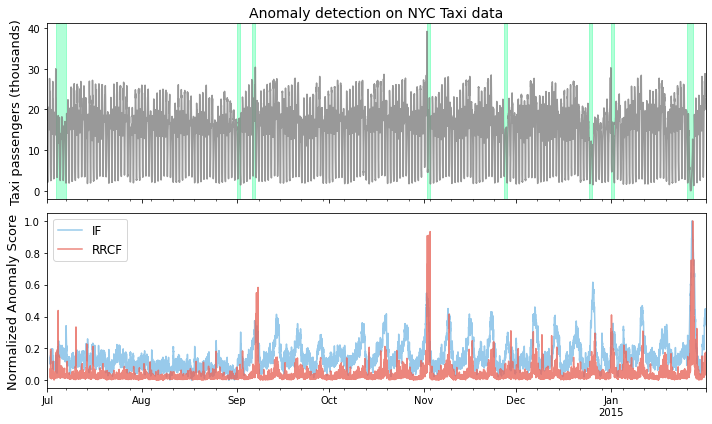

In [13]:
# Normalize anomaly scores to (0, 1)
avg_codisp = ((avg_codisp - avg_codisp.min())
              / (avg_codisp.max() - avg_codisp.min()))
if_scores = ((if_scores - if_scores.min())
              / (if_scores.max() - if_scores.min()))
              
fig, ax = plt.subplots(2, figsize=(10, 6))
(taxi['value'] / 1000).plot(ax=ax[0], color='0.5',
                            alpha=0.8)
if_scores.plot(ax=ax[1], color='#7EBDE6', alpha=0.8,
               label='IF')
avg_codisp.plot(ax=ax[1], color='#E8685D', alpha=0.8,
                label='RRCF')
ax[1].legend(frameon=True, loc=2, fontsize=12)

for event, duration in events.items():
    start, end = duration
    ax[0].axvspan(start, end, alpha=0.3,
                  color='springgreen')

ax[0].set_xlabel('')
ax[1].set_xlabel('')

ax[0].set_ylabel('Taxi passengers (thousands)', size=13)
ax[1].set_ylabel('Normalized Anomaly Score', size=13)
ax[0].set_title('Anomaly detection on NYC Taxi data',
                size=14)

ax[0].xaxis.set_ticklabels([])

ax[0].set_xlim(taxi.index[0], taxi.index[-1])
ax[1].set_xlim(taxi.index[0], taxi.index[-1])
plt.tight_layout()